Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import drive
from tensorflow.keras import layers, Model


Data Loader

Mounted at /content/drive
LR images shape: (10000, 1, 75, 75)
HR images shape: (10000, 1, 150, 150)
Number of LR images: 10000
Number of HR images: 10000
Shape of one LR image: (1, 75, 75)
Shape of one HR image: (1, 150, 150)
Sample entry [[[0.01615789 0.01594497 0.01057685 ... 0.01319846 0.00957293 0.01057328]
  [0.00752465 0.0165968  0.00791955 ... 0.00631138 0.01182699 0.01349821]
  [0.01239913 0.00841438 0.01346253 ... 0.01260134 0.01169615 0.01562262]
  ...
  [0.0098703  0.00553465 0.01051619 ... 0.01284162 0.01085876 0.01160337]
  [0.01119062 0.01489942 0.01275717 ... 0.01027234 0.01060302 0.01406083]
  [0.00916613 0.01467936 0.0093957  ... 0.01376465 0.01052213 0.01082307]]]


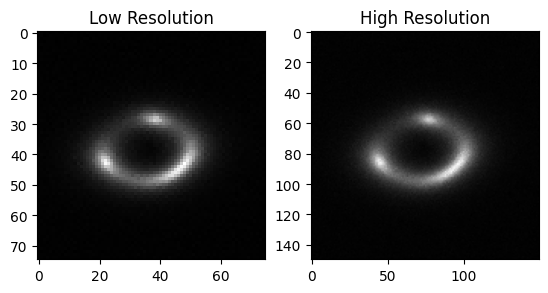

In [3]:
drive.mount('/content/drive')
'''
# Paths to LR and HR folders
lr_path = '/content/drive/My Drive/Lensing Resources/Dataset/LR'
hr_path = '/content/drive/My Drive/Lensing Resources/Dataset/HR'


# Function to load images from a folder and convert them to NumPy arrays
def load_images_to_numpy(folder_path):
    images = []
    for filename in os.listdir(folder_path):
          img_path = os.path.join(folder_path, filename)
          img_array = np.load(img_path)
          images.append(img_array)
    return np.array(images)

lr_images = load_images_to_numpy(lr_path)
hr_images = load_images_to_numpy(hr_path)
'''
#This takes too much time, trying to load zip and extract here. Should be faster.

import zipfile

zip_path = '/content/drive/My Drive/Lensing Resources/3a_Dataset.zip'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/3a_Dataset')

# Load all .npy files from the extracted folder
lr_path = '/content/3a_Dataset/Dataset/LR'
hr_path = '/content/3a_Dataset/Dataset/HR'

lr_files = sorted([os.path.join(lr_path, f) for f in os.listdir(lr_path) if f.endswith('.npy')])
hr_files = sorted([os.path.join(hr_path, f) for f in os.listdir(hr_path) if f.endswith('.npy')])

lr_images = np.array([np.load(f) for f in lr_files])
hr_images = np.array([np.load(f) for f in hr_files])



# Just verifying stuff
print("LR images shape:", lr_images.shape)
print("HR images shape:", hr_images.shape)
print(f"Number of LR images: {len(lr_images)}")
print(f"Number of HR images: {len(hr_images)}")
print(f"Shape of one LR image: {lr_images[0].shape}")
print(f"Shape of one HR image: {hr_images[0].shape}")
print("Sample entry", lr_images[0])
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Low Resolution')
plt.imshow(lr_images[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('High Resolution')
plt.imshow(hr_images[0].squeeze(), cmap='gray')

Defining RCAN

In [4]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add, Layer
from tensorflow.keras.models import Model
# Define Channel Attention Module
def channel_attention(input_feature, ratio=16):
    channels = input_feature.shape[-1]
    ga_pool = GlobalAveragePooling2D()(input_feature)
    ga_pool = Reshape((1, 1, channels))(ga_pool)
    dense1 = Dense(channels // ratio, activation='relu')(ga_pool)
    dense2 = Dense(channels, activation='sigmoid')(dense1)
    return dense2

# Define Residual Channel Attention Block (RCAB)
def rcab(inputs, num_filters=64, ratio=16):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.activations.relu(x)
    x = Conv2D(num_filters, 3, padding='same')(x)
    ca = channel_attention(x, ratio)
    x = Multiply()([x, ca])
    x = Add()([x, inputs])
    return x

# Define Residual Group
def residual_group(inputs, num_rcab=5, num_filters=64, ratio=16):
    x = inputs
    for _ in range(num_rcab):
        x = rcab(x, num_filters, ratio)
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, inputs])
    return x

# Custom Layer for Depth-to-Space (PixelShuffle)
class DepthToSpace(Layer):
    def __init__(self, scale, **kwargs):
        super(DepthToSpace, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(DepthToSpace, self).get_config()
        config.update({'scale': self.scale})
        return config

# Build RCAN Model
def build_rcan(input_shape=(75, 75, 1), scale=2, num_rg=5, num_rcab=5, num_filters=64, ratio=16):
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    initial = x

    # Residual Groups
    for _ in range(num_rg):
        x = residual_group(x, num_rcab, num_filters, ratio)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = Add()([x, initial])

    # Upsampling
    x = Conv2D(num_filters * (scale ** 2), 3, padding='same')(x)
    x = DepthToSpace(scale)(x)  # Use custom layer for depth_to_space
    x = Conv2D(1, 3, padding='same', activation='relu')(x)

    return Model(inputs, x)


# Create the RCAN Model
model = build_rcan()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75, 75, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 75, 75, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 75, 75, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 75, 75, 64)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 75, 75, 64)     │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_2[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 4)        │            260 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 75, 75, 64)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 75, 75, 64)     │              0 │ multiply[0][0],        │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 75, 75, 64)     │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 75, 75, 64)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 75, 75, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_4[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 1, 4)        │            260 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 2,231,397 (8.51 MB)

 Trainable params: 2,231,397 (8.51 MB)

 Non-trainable params: 0 (0.00 B)

Checkpointing

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/Lensing Resources/3a_checkpointing.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model
    mode='min',
    verbose=1
)

Compile Model

In [6]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0)  # Clip gradients to [-1.0, 1.0]
#model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')


Process Data

(10000, 1, 75, 75)
(10000, 1, 150, 150)
(10000, 75, 75, 1)
(10000, 150, 150, 1)


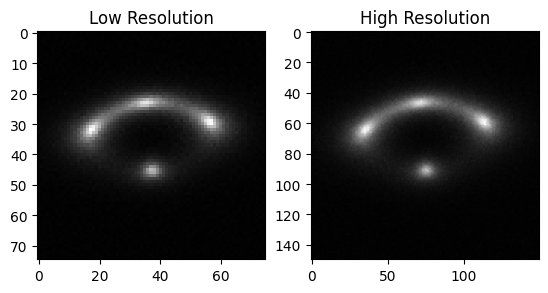

In [7]:
# Reshape LR and HR images to add channel dimension (if not already present)
print(lr_images.shape)
print(hr_images.shape)
lr_images = lr_images.reshape(-1, 75, 75, 1)
hr_images = hr_images.reshape(-1, 150, 150, 1)
print(lr_images.shape)
print(hr_images.shape)
# Normalize pixel values to [0, 1] (if not already normalized)
#lr_images = lr_images.astype('float32') / 255.0
#hr_images = hr_images.astype('float32') / 255.0

# Split into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(lr_images, hr_images, test_size=0.2, random_state=42)

# Create TensorFlow Datasets, because some pipeline issue
def create_dataset(lr, hr, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((lr, hr))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)


#print(model.weights)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Low Resolution')
plt.imshow(X_train[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('High Resolution')
plt.imshow(y_train[0].squeeze(), cmap='gray')

Train Model

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[checkpoint_callback]
)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.0051
Epoch 1: val_loss improved from inf to 0.00011, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 431ms/step - loss: 0.0051 - val_loss: 1.0940e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 1.0007e-04
Epoch 2: val_loss improved from 0.00011 to 0.00008, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 412ms/step - loss: 1.0004e-04 - val_loss: 8.2282e-05
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 7.9774e-05
Epoch 3: val_loss improved from 0.00008 to 0.00007, saving model to /content/drive/My Drive/Lensing Resources/3a_checkpointing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 412ms/step - loss: 7.9764e-05 - val_loss: 7.3468e-05
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 7.2536e-05
Epoch 4: val_loss improved from 0.00007 to 0.00007, savi

In [9]:
model.weights

[<Variable path=conv2d/kernel, shape=(3, 3, 1, 64), dtype=float32, value=[[[[ 0.06884089 -0.0310525  -0.06286828 -0.05936114 -0.04114458
      0.08026387  0.0088927  -0.04504945  0.0551312   0.01683531
     -0.02183937 -0.04349134  0.09331363  0.09610362 -0.05431589
     -0.06226525 -0.01918249  0.0203585   0.0430064  -0.0862493
      0.02124817 -0.05240179  0.04757972  0.05948245  0.0834038
     -0.08356678 -0.0706144   0.04575962  0.0522643  -0.06921934
     -0.09165081  0.06848218 -0.04565375 -0.0097686  -0.00042933
     -0.04369445  0.01422124  0.00543167  0.04020446 -0.0587418
     -0.05996478  0.07008268 -0.02968576 -0.02274525 -0.05209977
     -0.04314456  0.02549429  0.06532919 -0.05293269  0.00350475
      0.0615162  -0.0475314  -0.02698055 -0.02590855 -0.00772413
     -0.09257441 -0.00806053 -0.00611744 -0.0041539  -0.07626582
     -0.06858859  0.06578123  0.03266004 -0.00924844]]
 
   [[-0.07172424 -0.04045849  0.08408275 -0.09152559  0.05248211
     -0.09478301 -0.07310104 

Evaluating Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0174
Validation Loss: 0.017404470592737198
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step


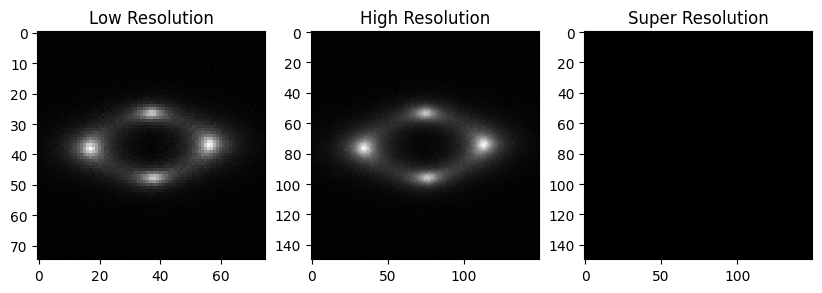

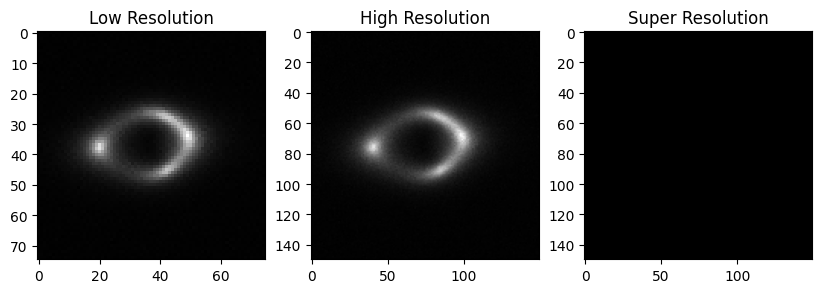

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


In [12]:
# Evaluate the model
#loss, mae = model.evaluate(X_val, y_val, verbose=1) havent added mae yet
loss = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss}")
#print(f"Validation MAE: {mae}")

# Visualize some predictions
import matplotlib.pyplot as plt

def plot_results(lr, hr, sr, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution')
    plt.imshow(lr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('High Resolution')
    plt.imshow(hr[index].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Super Resolution')
    plt.imshow(sr[index].squeeze(), cmap='gray')
    plt.show()

# Generate super-resolution images
sr_images = model.predict(X_val)

# Plot some results
plot_results(X_val, y_val, sr_images, index=0)
plot_results(X_val, y_val, sr_images, index=1)
print(sr_images[0])

Saving the model

In [11]:
from tensorflow.keras.models import load_model

# Load the entire model
#model = load_model(checkpoint_path)
#print("Best model loaded.")
# Evaluate the best model
#loss, mae = rcan_model.evaluate(X_val, y_val, verbose=1)loss, mae = rcan_model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {loss}")
#print(f"Validation MAE: {mae}")

final_model_path = '/content/drive/My Drive/Lensing Resources/3a_best_checkpoint.keras)'
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mse', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Could not locate class 'DepthToSpace'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'DepthToSpace', 'config': {'name': 'depth_to_space', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 138794577902288}, 'scale': 2}, 'registered_name': 'DepthToSpace', 'build_config': {'input_shape': [None, 75, 75, 256]}, 'name': 'depth_to_space', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 75, 75, 256], 'dtype': 'float32', 'keras_history': ['conv2d_57', 0, 0]}}], 'kwargs': {}}]}